傾向スコアを使用したセミパラメトリックな差分の差推定
https://tech.ledge.co.jp/entry/Difference-in-Differences

本稿ではプリンストン大学で提供されているデータセットを使用して、推定量を求めます。このデータセットは、AからGの7か国を対象にした1990年から1999年のパネルデータであり、1994年にF,F,G国で何かしらの介入があったという設定が置かれています。

それでは以下、推定量の算出を行います。

データの読み込みと整形

---



In [3]:
# データ読み込み用
from pandas import read_stata
import pandas as pd
from sklearn.linear_model import LogisticRegression
# 描画用
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns

sns.set_style('white')
panel_data = read_stata("https://dss.princeton.edu/training/Panel101.dta")
panel_data.head()

,country,year,y,y_bin,x1,x2,x3,opinion,op
0,A,1990,1.342788e+09,1.0,0.277904,-1.107956,0.282554,Str agree,1.0
1,A,1991,-1.899661e+09,0.0,0.320685,-0.948720,0.492538,Disag,0.0
2,A,1992,-1.123436e+07,0.0,0.363466,-0.789484,0.702523,Disag,0.0
3,A,1993,2.645775e+09,1.0,0.246144,-0.885533,-0.094391,Disag,0.0
4,A,1994,3.008335e+09,1.0,0.424623,-0.729768,0.946131,Disag,0.0


In [4]:
#処置群と対照群、1993年と1994年のデータの作成
# 介入フラグの作成（E,F,G国が介入対象）
panel_data["treatment"] = panel_data["country"].apply(lambda x : 1 if x == "E" or x == "F" or x == "G" else 0)
# 介入前（1993年）と後（1994年）のデータのみに絞り込む
panel_data_1993 = panel_data.query("year == 1993").reset_index(drop = True)
panel_data_1994 = panel_data.query("year == 1994").reset_index(drop = True)[["country","y"]]
# カラム名を変更
panel_data_1993.rename(columns={"y":"y1993"}, inplace=True)
panel_data_1994.rename(columns={"y":"y1994"}, inplace=True)
# 国ごとに共変量と介入前後の結果変数をカラムに持つように変換
panel_data_target = panel_data_1993.merge(panel_data_1994, on="country")
panel_data_target.head()

,country,year,y1993,y_bin,x1,x2,x3,opinion,op,treatment,y1994
0,A,1993,2.645775e+09,1.0,0.246144,-0.885533,-0.094391,Disag,0.0,0,3.008335e+09
1,B,1993,3.072742e+09,1.0,0.726777,1.691758,0.256224,Str disag,0.0,0,3.768079e+09
2,C,1993,1.225180e+09,1.0,1.421545,-1.311745,-0.375966,Disag,0.0,0,3.802288e+09
3,D,1993,5.067265e+09,1.0,0.209444,1.614977,-0.212578,Str agree,1.0,0,3.882478e+09
4,E,1993,1.139731e+08,1.0,-0.244288,1.649284,1.224133,Str agree,1.0,1,2.600980e+08


傾向スコアの推定
共変量（x1, x2, x3, opinion）をもとに各国の傾向スコアを求めます。

---



In [10]:
y = panel_data_target["treatment"]
X = pd.get_dummies(panel_data_target[["x1", "x2", "x3", "opinion"]], columns=["opinion"], drop_first=True)

ps_model_did = LogisticRegression(solver="lbfgs").fit(X, y)
ps_score_did = ps_model_did.predict_proba(X)[:, 1]

X.head()
#ps_score_did

,x1,x2,x3,opinion_Agree,opinion_Disag,opinion_Str disag
0,0.246144,-0.885533,-0.094391,0,1,0
1,0.726777,1.691758,0.256224,0,0,1
2,1.421545,-1.311745,-0.375966,0,1,0
3,0.209444,1.614977,-0.212578,0,0,0
4,-0.244288,1.649284,1.224133,0,0,0




---


DID推定量の算出
まず初めに、介入のあった国とそうでない国における平均値の推移を確認します。


---



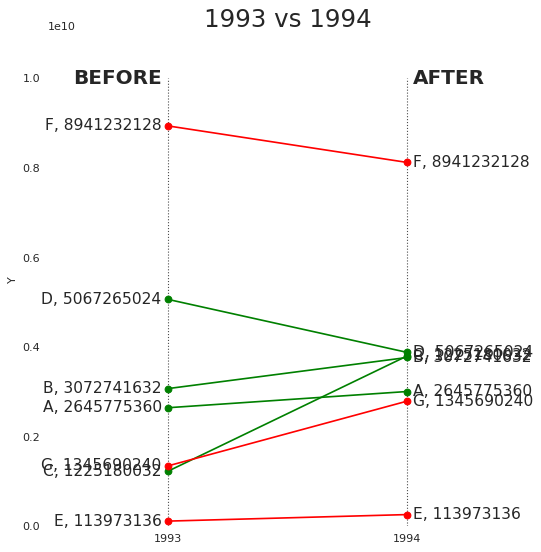

In [8]:
# 介入前後の結果変数の描画
def plot_before_and_after_treatment(
    before_treatment_y,
    after_treatment_y,
    treatment_f,
    before_treatment_x=1,
    after_treatment_x=3,
    color='black'
):
    ax = plt.gca()
    l = mlines.Line2D(
        [before_treatment_x, after_treatment_x],
        [before_treatment_y, after_treatment_y],
        color='red' if treatment_f else 'green',
        marker='o',
        markersize=6
    )
    ax.add_line(l)
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(7,7), dpi=80)
before_treatment_x = 1
after_treatment_x = 3
ax.vlines(x=before_treatment_x, ymin=500, ymax=10**10, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=after_treatment_x, ymin=500, ymax=10**10, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
for y1993, y1994, country, treatment in np.array(panel_data_target[['y1993', 'y1994', 'country', 'treatment']]):
    plot_before_and_after_treatment(
        before_treatment_y=y1993,
        after_treatment_y=y1994,
        treatment_f=treatment,
    )
    # サンプルにラベルを付与
    ax.text(before_treatment_x-0.05, y1993, f'{country}, {round(y1993)}', horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
    ax.text(after_treatment_x+0.05, y1994, f'{country}, {round(y1993)}', horizontalalignment='left', verticalalignment='center', fontdict={'size':14})
# vlilneにラベルを付与
ax.text(before_treatment_x-0.05, 10**10, 'BEFORE', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
ax.text(after_treatment_x+0.05, 10**10, 'AFTER', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})
ax.set_title("1993 vs 1994", fontdict={'size':22})
ax.set(xlim=(0,4), ylim=(0,11000000000), ylabel='Y')
ax.set_xticks([before_treatment_x, after_treatment_x])
ax.set_xticklabels(["1993", "1994"])
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)
plt.tight_layout()
plt.show()

介入のあった国における2時点の差分だけを確認します。

---



In [11]:
# 差分の差を取らない場合
diff_tg = panel_data_target[panel_data_target["treatment"]==1]["y1994"].mean() - panel_data_target[panel_data_target["treatment"]==1]["y1993"].mean()
diff_tg

259074042.6666665

次に、単純な差分の差、すなわち➀介入前後の時系列的な差分と、➁処置群と対照群における差分、の2つの差分を使用してDID推定量を確認します。

---



In [12]:
# 単純な差分の差
# 介入が行われた国の時系列的な差分
diff_tg = panel_data_target[panel_data_target["treatment"]==1]["y1994"].mean() - panel_data_target[panel_data_target["treatment"]==1]["y1993"].mean()
# 介入が行われていない国の時系列的な差分
diff_ntg = panel_data_target[panel_data_target["treatment"]==0]["y1994"].mean() - panel_data_target[panel_data_target["treatment"]==0]["y1993"].mean()
# 処置群と対照群における差分
did = diff_tg - diff_ntg
did

-353480357.3333335

最後に先述した式に倣って、セミパラメトリックな差分の差推定量を算出します。

---



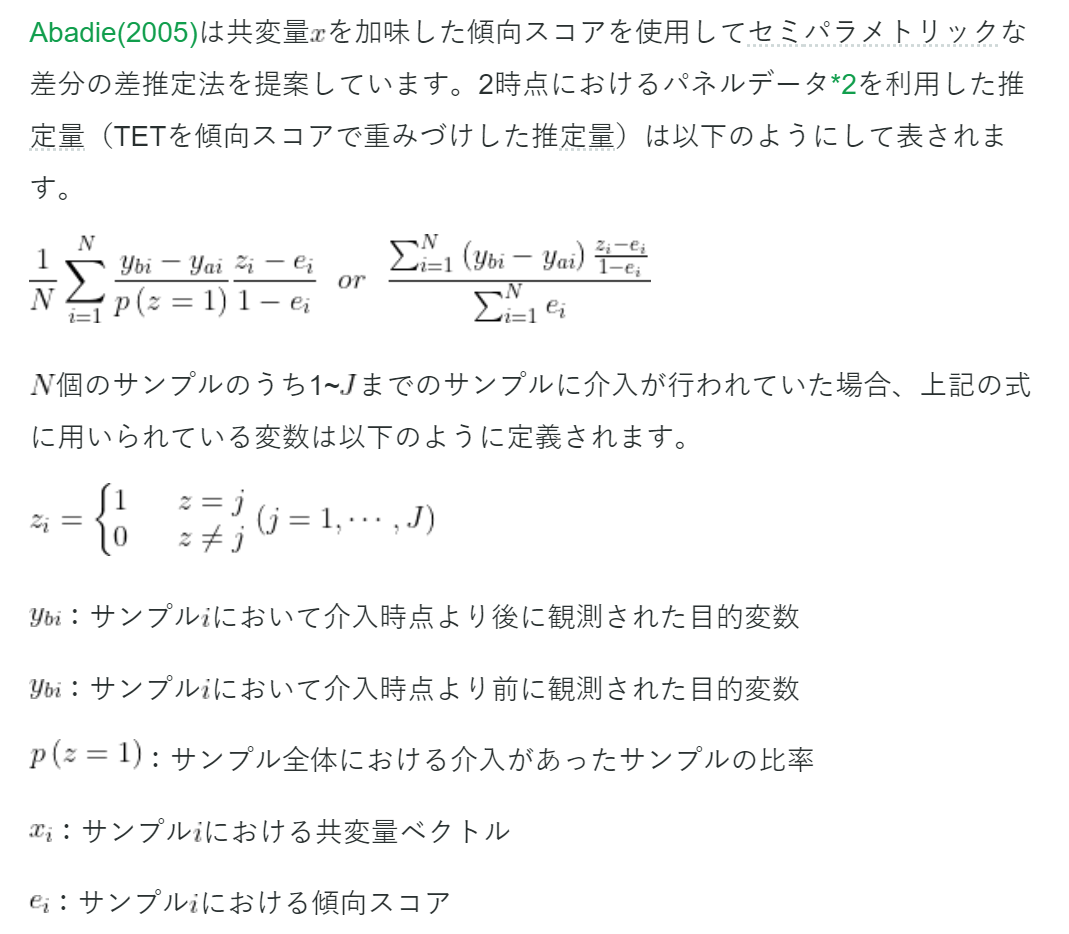

In [13]:
yb = panel_data_target["y1994"]
ya = panel_data_target["y1993"]
z = panel_data_target["treatment"]
e = ps_score_did
Semiparametric_did = sum((yb - ya) * (z - e)/(1 - e)) / sum(e)
Semiparametric_did  

-13569454.512583178